<center><h1> Multiclass Predictive Modeling </h1></center>
<center><h2> National Bureau of Economic Research Working Papers </h2></center>

## Data Exploration

In [2]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
papers = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-28/papers.csv")
programs = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-28/programs.csv")
paper_programs = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-28/paper_programs.csv")

In [4]:
papers_joined = pd.merge(paper_programs, programs, on = "program")
papers_joined = pd.merge(papers_joined, papers, on = "paper")
papers_joined = papers_joined[papers_joined["program_category"].notnull()]
papers_joined = papers_joined.drop_duplicates(subset=["paper", "program_category", "year", "title"])

How many papers belong to each program?

Text(0.5, 1.0, 'Working Papers by Program')

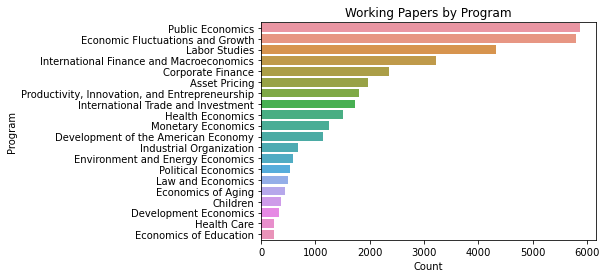

In [15]:
sns.countplot(y = "program_desc", data = papers_joined, order = papers_joined["program_desc"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Program")
plt.title("Working Papers by Program")

How many papers are in each program category?

In [5]:
papers_joined["program_category"].value_counts()

Micro                  18527
Macro/International    12012
Finance                 4336
Name: program_category, dtype: int64

Text(0.5, 1.0, 'Working Papers by Program Category')

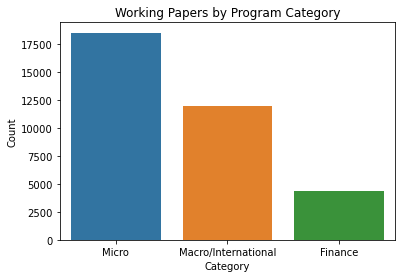

In [17]:
sns.countplot(x = "program_category", data = papers_joined, order = papers_joined["program_category"].value_counts().index)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Working Papers by Program Category")

The model will need to address the fact that this is an imbalanced dataset with three classes.

## Predictive Modeling

Split the data into dependent and independent variables

In [6]:
X = papers_joined["title"]
y = papers_joined["program_category"]

In [7]:
stop_words = set(stopwords.words('english'))
def clean_titles(str_list, lemmatize = True):
    clean_list = []

    # 1. Convert to lowercase and create tokens
    for text in str_list:
        text = text.lower()
        words = word_tokenize(text)
        clean_words = []

        # 2. Remove English stopwords and lemmatize
        for word in words:

            if word not in stop_words:

                if lemmatize:
                    lemmatizer = WordNetLemmatizer()

                clean_words.append(word)
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)

    return clean_list

Perform a stratified train test split

In [8]:
X = clean_titles(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)

Vectorize the paper titles

In [9]:
tfidf = TfidfVectorizer()

Naive Bayes Classifier

In [10]:
nb_pipe = Pipeline([
    ("vectorize", tfidf),
    ("classify", MultinomialNB())
])
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize', TfidfVectorizer()),
                ('classify', MultinomialNB())])

Now that the model has been fit with the training data, let's see how it performs on the testing data.

In [11]:
from sklearn.metrics import classification_report
y_pred = nb_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

            Finance       0.52      0.05      0.09      1301
Macro/International       0.63      0.64      0.63      3604
              Micro       0.72      0.87      0.79      5558

           accuracy                           0.69     10463
          macro avg       0.62      0.52      0.51     10463
       weighted avg       0.66      0.69      0.65     10463



Ridge Classifier

In [14]:
ridge_pipe = Pipeline([
    ("vectorize", tfidf),
    ("classify", RidgeClassifier())
])
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize', TfidfVectorizer()),
                ('classify', RidgeClassifier())])

Now that the model has been fit with the training data, let's see how it performs on the testing data.

In [15]:
y_pred = ridge_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

            Finance       0.44      0.30      0.35      1301
Macro/International       0.62      0.59      0.61      3604
              Micro       0.74      0.81      0.77      5558

           accuracy                           0.67     10463
          macro avg       0.60      0.57      0.58     10463
       weighted avg       0.66      0.67      0.66     10463

